# Exploring the Discharge Notes Data

In [1]:
# import libraries
import os
from dotenv import load_dotenv, find_dotenv
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import string
from yellowbrick.text import FreqDistVisualizer

# set style
sns.set_style('dark')

%matplotlib inline
%load_ext watermark

PROJ_ROOT = os.path.join(os.pardir)

In [2]:
%watermark -a "E. Chris Lynch" -d -t -v -p numpy,pandas,matplotlib,nltk,sklearn

E. Chris Lynch 2018-12-20 17:06:22 

CPython 3.7.1
IPython 7.2.0

numpy 1.15.4
pandas 0.23.4
matplotlib 2.2.3
nltk 3.4
sklearn 0.20.1


In [36]:
# load the data
train_df = pd.read_csv(os.path.join(PROJ_ROOT, 'data', 'processed','clinic_train_data.csv'), index_col=0)
train_df.head()

,subject_id,hadm_id,admission_time,discharge_time,next_admission,days_between_admit,admission_type,time_of_death,text,readmission
0,60476,106006,2198-06-12 08:00:00,2198-06-29 13:00:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2198-6-12**] ...,0
2,5928,140311,2153-09-02 22:31:00,2153-09-14 18:25:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2153-9-2**] D...,0
3,11003,163654,2123-03-01 23:30:00,2123-03-10 15:24:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2123-3-1**] D...,0
5,45635,131714,2163-07-18 15:24:00,2163-07-22 16:52:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2163-7-18**] ...,0
8,81398,105262,2192-04-09 16:31:00,2192-04-18 17:57:00,NaN,NaN,EMERGENCY,NaN,Admission Date: [**2192-4-9**] D...,0


In [37]:
train_df.groupby('readmission')['text'].describe()

,count,unique,top,freq
readmission,,,,
0,33625,32410,,1216
1,2154,2119,,36


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35779 entries, 0 to 51112
Data columns (total 10 columns):
subject_id            35779 non-null int64
hadm_id               35779 non-null int64
admission_time        35779 non-null object
discharge_time        35779 non-null object
next_admission        7821 non-null object
days_between_admit    7821 non-null float64
admission_type        35779 non-null object
time_of_death         4091 non-null object
text                  35779 non-null object
readmission           35779 non-null int64
dtypes: float64(1), int64(3), object(6)
memory usage: 3.0+ MB


In [39]:
train_df.text[0]

"Admission Date:  [**2198-6-12**]              Discharge Date:   [**2198-6-29**]  Date of Birth:  [**2121-7-24**]             Sex:   F  Service: CARDIOTHORACIC  Allergies: Penicillins / Sulfur  Attending:[**First Name3 (LF) 5790**] Chief Complaint: Dehydration, left recurrent chylothorax  Major Surgical or Invasive Procedure: [**2198-5-30**] and [**2198-6-8**]: Ultrasound-guided therapeutic thoracentesis (outpt) [**2198-6-13**]: Left video-assisted thoracoscopy exploration and fibrin glue application. Right video-assisted thoracoscopy thoracic duct ligation and fibrin glue. [**2198-6-22**]: Interventional Radiology - lymphangiography with embolism of upper abdominal lymphatics up to the level of cisterna chyli with microcoils and gelfoam slurry [**2198-6-25**] Right pigtail placement for large pleural effusion removed [**2198-6-28**]   History of Present Illness: Ms. [**Known lastname 6955**] is a pleasant 76 year old female who underwent video-assisted thoracoscopic surgery left upper

## Explore Vectorized Text

In [6]:
def clean_and_tokenize(text):
    '''
    tokenize the text by replacing punctuation and 
    numbers with spaces and lowercase all words
    '''
    
    punc_list = string.punctuation + string.digits
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [40]:
# instantiate Count Vectorizer
vect = CountVectorizer(max_features=3000, tokenizer=clean_and_tokenize, stop_words='english')

# fit training data to vectorizer
vect_fit = vect.fit_transform(train_df.text.values)

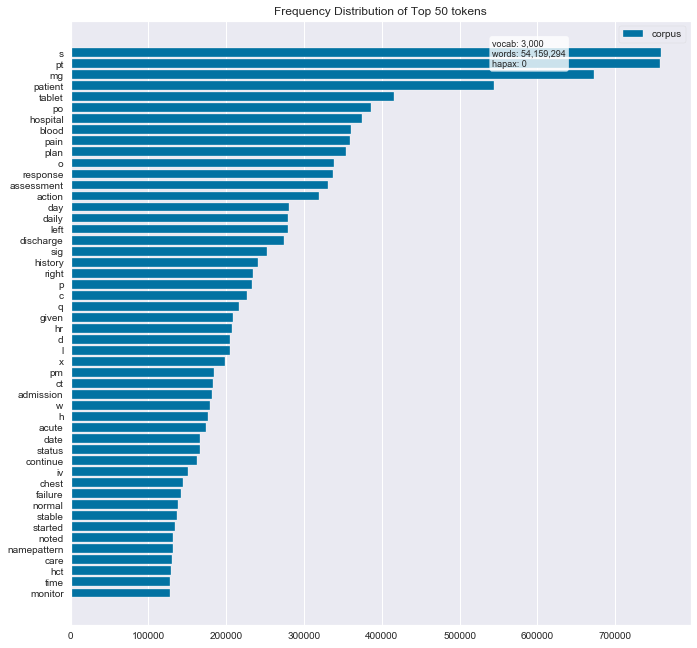

In [41]:
# get the feature names
features = vect.get_feature_names()

# plot word distributions
visualizer = FreqDistVisualizer(features=features, size=(800,800))
visualizer.fit(vect_fit)
visualizer.poof(outpath=os.path.join(PROJ_ROOT, 'reports',
                               'figures','word_freq_countvec.png'))

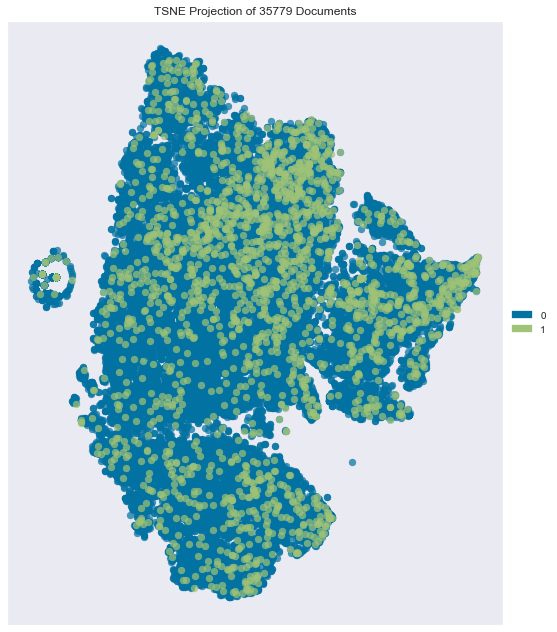

In [42]:
from yellowbrick.text import TSNEVisualizer

# tSNE plot
tsne = TSNEVisualizer(size=(800,800))
tsne.fit(vect_fit, train_df.readmission)
tsne.poof(outpath=os.path.join(PROJ_ROOT, 'reports',
                               'figures','tsne_countvec.png'))

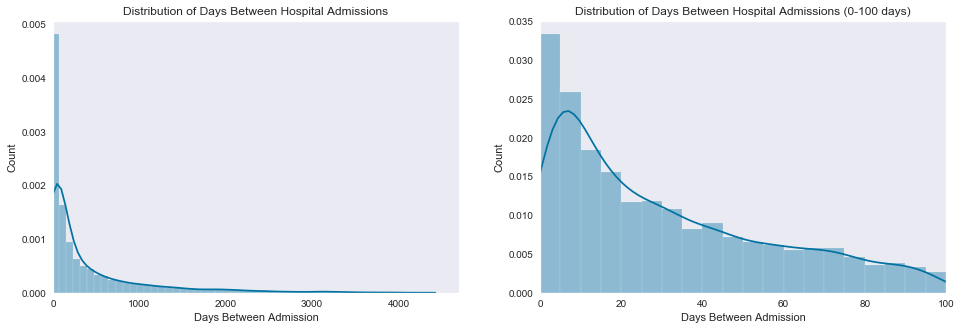

In [60]:
# plot distribution of days between admission
days_between = train_df[train_df.days_between_admit.notnull()]['days_between_admit'].values
first_100_days = train_df[(train_df.days_between_admit >=0) & (train_df.days_between_admit <= 100)]['days_between_admit'].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(days_between, ax=ax[0])
#train_df.days_between_admit.hist(bins=20, ax=ax[0])
ax[0].set_title('Distribution of Days Between Hospital Admissions')
ax[0].set_xlabel('Days Between Admission')
ax[0].set_ylabel('Count')
ax[0].set_xlim([0,4700])

sns.distplot(first_100_days, ax=ax[1])
#train_df.days_between_admit.hist(bins=10, ax=ax[1])
ax[1].set_title('Distribution of Days Between Hospital Admissions (0-100 days)')
ax[1].set_xlabel('Days Between Admission')
ax[1].set_ylabel('Count')
ax[1].set_xlim([0,100])

plt.savefig(os.path.join(PROJ_ROOT, 'reports',
                         'figures','days_between_distro.png'))